<a href="https://colab.research.google.com/github/eraraya-ricardo/congklak_game/blob/master/congklak_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount google drive to our notebook

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Git Commit

In [20]:
%cd "/content/gdrive/My Drive/Projects/Congklak/congklak_game"

/content/gdrive/My Drive/Projects/Congklak/congklak_game


In [21]:
!git status

On branch testing
Your branch is up to date with 'origin/testing'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   congklak_ai.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [22]:
!git add -u

# Import Custom File

In [10]:
%cd "/content/gdrive/My Drive/Projects/Congklak/congklak_game"

/content/gdrive/My Drive/Projects/Congklak/congklak_game


In [12]:
import imp 
board = imp.new_module('congklak_env')
exec(open("./congklak_env.py").read(), board.__dict__)

In [16]:
cb = board.congklak_board()

In [18]:
cb.setup(7, 3000)

In [ ]:
import random
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import model_from_json


# the agent
class agent:
    def __init__(self, observation_space, action_space, exp_init, exp_min, decay, gamma, learning_rate, memory_size, batch):
        self.exploration_rate = exp_init
        self.EXPLORATION_MIN = exp_min
        self.DECAY_RATE = decay
        self.GAMMA = gamma
        self.LEARNING_RATE = learning_rate
        self.MEMORY_SIZE = memory_size
        self.BATCH_SIZE = batch

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        self.model = Sequential()
        self.model.add(Dense(30, input_shape=(observation_space,), activation="sigmoid"))
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=self.LEARNING_RATE))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        q_values = self.model.predict(state.reshape(1,-1))
        return np.argmax(q_values[0])

    def experience_replay(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        batch = random.sample(self.memory, self.BATCH_SIZE)
        for state, action, reward, state_next, terminal in batch:
            q_update = reward
            if not terminal:
                q_update = (reward + self.GAMMA * np.amax(self.model.predict(state_next.reshape(1,-1))[0]))
            q_values = self.model.predict(state.reshape(1,-1))
            q_values[0][action] = q_update
            self.model.fit(state.reshape(1,-1), q_values, verbose=0)
        self.exploration_rate *= self.DECAY_RATE
        self.exploration_rate = max(self.EXPLORATION_MIN, self.exploration_rate)

    def save_model(self, fdir):
        # serialize model to JSON
        model_json = self.model.to_json()
        with open(fdir + ".json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.model.save_weights(fdir + ".h5")
        print("Saved model to disk")

    def load_model(self, fdir):
        # load json and create model
        json_file = open(fdir + ".json", "r")
        model = json_file.read()
        json_file.close()
        self.model = model_from_json(model)
        # load weights into new model
        self.model.load_weights(fdir + ".h5")
        self.model.compile(loss='mse', optimizer=Adam(lr=self.LEARNING_RATE), metrics=['accuracy'])
        print("Loaded model from disk")


In [ ]:
# hyperparameters and other constants setup

EXPLORATION_INIT = 1.0
EXPLORATION_MIN = 0.01
DECAY_RATE = 0.99995

# discount factor
GAMMA = 0.95
# step size for Adam
LEARNING_RATE = 0.001

# maximum capacity of the replay memory
MEMORY_SIZE = 5000
# Number of data samples from the replay memory in one step of training
BATCH_SIZE = 32

# reward function parameter
alfa = 0.8 # keeping distance from opponent
beta = 0.2 # gaining stone
zeta = 1  # winning

# board size
N = 7

# max iteration
MAX_ITER = 3000

model_dir = "/content/gdrive/My Drive/Congklak/Model/model"
log_dir = "/content/gdrive/My Drive/Congklak/Log/log"


In [ ]:
def softsign(x):
    return x/(abs(x) + 1)

In [ ]:
# TRAINING

import tensorflow as tf

# environment setup
cb = congklak_board()
cb.setup(7, MAX_ITER)
action_space = cb.action_space()
observation_space = cb.observation_space()
    
# agent setup
player = agent(observation_space, action_space, EXPLORATION_INIT, EXPLORATION_MIN, DECAY_RATE, GAMMA, LEARNING_RATE, MEMORY_SIZE, BATCH_SIZE)
# continue training
player.load_model(model_dir)
    
# determining whether the agent goes first or second
player_turn = 0
    
games_played = 0
prev_score = 0
win_con = 0
    
while games_played < MAX_ITER:
    games_played += 1
    flag = 0
    cb.reset()
        
    while True:
            
        # agent's move
        if cb.whose_turn() == player_turn:
            player.experience_replay()
            if cb.possible_action().shape[0] != 0:
                flag = 1
                state = cb.one_hot_state()
                action = player.act(state)
                cb.step(action)
                if cb.whose_turn() == player_turn:
                    terminal = cb.done
                    state_next = cb.one_hot_state()
                    if cb.is_legal(action):
                        if cb.done:
                            if cb.score[0] == cb.score[1]:
                                win_con = 0
                            else:
                                if cb.whose_turn() == player_turn:
                                    win_con = 1
                                else:
                                    win_con = 0
                        reward = softsign(alfa*(cb.score[player_turn] - cb.score[int(not(player_turn))]) + beta*(cb.score[player_turn] - prev_score) + zeta*int(win_con))
                        prev_score = cb.score[player_turn]
                    else:
                        reward = -1
                    player.remember(state, action, reward, state_next, terminal)
            else:
                cb.end_turn()
        
        # random move
        else:
            if cb.possible_action().shape[0] != 0:
                random_action = np.random.choice(cb.possible_action())
                cb.step(random_action)
            else:
                cb.end_turn()
            if cb.whose_turn() == player_turn and flag == 1:
                terminal = cb.done
                state_next = cb.one_hot_state()
                if cb.done:
                    if cb.score[0] == cb.score[1]:
                        win_con = 0
                    else:
                        if cb.whose_turn() == player_turn:
                            win_con = 1
                        else:
                            win_con = 0
                reward = softsign(alfa*(cb.score[player_turn] - cb.score[int(not(player_turn))]) + beta*(cb.score[player_turn] - prev_score) + zeta*int(win_con))
                prev_score = cb.score[player_turn]
                player.remember(state, action, reward, state_next, terminal)

        # checking whether the game is end or not            
        if cb.done:
            cb.logging(cb.score)
            print("Game " + str(games_played) + " is over. Final score: Player = " + str(cb.score[player_turn]))
            if cb.score[0] == cb.score[1]:
                print("Result: Draw.")
            else:
                if cb.whose_turn() == player_turn:
                    print("Result: Win.")
                else:
                    print("Result: Lose.")
            if games_played >= MAX_ITER*0.2:
                print("Average score of the last " + str(int(MAX_ITER*0.2)) + " games =", cb.log[-1,(2+player_turn)])
            break
                
    if games_played%10 == 0:
      player.save_model(model_dir)
      cb.log_to_txt(log_dir)

Streaming output truncated to the last 5000 lines.
Game 423 is over. Final score: Player = 49
Result: Draw.
Game 424 is over. Final score: Player = 40
Result: Lose.
Game 425 is over. Final score: Player = 36
Result: Lose.
Game 426 is over. Final score: Player = 57
Result: Win.
Game 427 is over. Final score: Player = 50
Result: Win.
Game 428 is over. Final score: Player = 36
Result: Lose.
Game 429 is over. Final score: Player = 47
Result: Lose.
Game 430 is over. Final score: Player = 50
Result: Win.
Saved model to disk
Log score to text file
Game 431 is over. Final score: Player = 50
Result: Win.
Game 432 is over. Final score: Player = 34
Result: Lose.
Game 433 is over. Final score: Player = 50
Result: Win.
Game 434 is over. Final score: Player = 50
Result: Win.
Game 435 is over. Final score: Player = 60
Result: Win.
Game 436 is over. Final score: Player = 42
Result: Lose.
Game 437 is over. Final score: Player = 45
Result: Lose.
Game 438 is over. Final score: Player = 50
Result: Win.
Ga

OSError: ignored

In [ ]:
player.exploration_rate

0.0433487044240018

In [ ]:
player_turn = 0

In [ ]:
win = 0
lose = 0

for i in range (len(tes)):
    if tes[i, player_turn] > tes[i, int(not(player_turn))]:
        win += 1
    elif tes[i, player_turn] < tes[i, int(not(player_turn))]:
        lose += 1

print("Win rate =", win/len(tes))
print("Lose rate =", lose/len(tes))

Win rate = 0.635
Lose rate = 0.32266666666666666


In [ ]:
player.exploration_rate

0.01

In [ ]:
import numpy as np
tes = np.loadtxt(log_dir + ".txt")

In [ ]:
tes.shape

(3000, 5)

In [ ]:
np.average(tes[:,4])

20.074333333333332

In [ ]:
score_logger = np.zeros((tes.shape[0]-600+1),)

for i in range (len(score_logger)):
    score_logger[i] = np.average(tes[i:(600+i), 0])

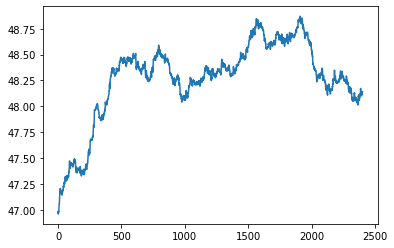

In [ ]:
from matplotlib import pyplot as plt

plt.plot(score_logger)

In [ ]:
tes[:, 2]

array([ 0.        ,  0.        ,  0.        , ..., 45.50166667,
       45.55      , 45.55      ])

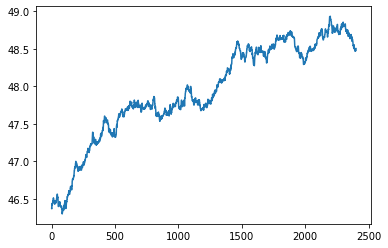

In [ ]:
plt.plot(cb.log[599::,2])

In [ ]:
cb.log[:,2]

array([ 0.        ,  0.        ,  0.        , ..., 45.28      ,
       45.28333333, 45.28333333])

In [ ]:
print(score_logger[1201])

IndexError: ignored

In [ ]:
cb.log[299:,2]

array([46.53333333, 46.53333333, 46.61666667, ..., 46.56      ,
       40.24      , 46.51666667])

In [ ]:
cb.log[int(len(cb.log)-0.1*cb.max_iter):len(cb.log), player_turn]

array([47., 50., 50., 19., 41., 50., 29., 52., 50., 52.])

In [ ]:
np.average(cb.log[int(len(cb.log)-0.1*cb.max_iter):len(cb.log), player_turn])

44.0

In [ ]:
-cb.log.shape

(3000, 2)

In [ ]:
cb.log[2999,0]

43

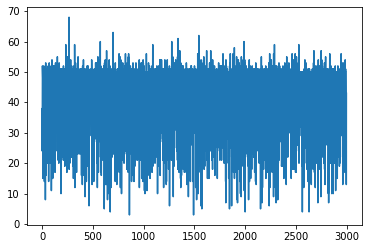

In [ ]:
from matplotlib import pyplot as plt

plt.plot(cb.log[:,0])

In [ ]:
import random
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import model_from_json


# the agent
class agent_test:
    def __init__(self, fdir):
        self.load_model(fdir)

    def act(self, state):
        q_values = self.model.predict(state.reshape(1,-1))
        return np.argmax(q_values[0])

    def load_model(self, fdir):
        # load json and create model
        json_file = open(fdir + ".json", "r")
        model = json_file.read()
        json_file.close()
        self.model = model_from_json(model)
        # load weights into new model
        self.model.load_weights(fdir + ".h5")
        print("Loaded model from disk")


In [ ]:
# hyperparameters and other constants setup

# step size for Adam
LEARNING_RATE = 0.01

# board size
N = 7

# max iteration
MAX_ITER = 3000

model_dir = "/content/gdrive/My Drive/Congklak/Model/model"
log_dir = "/content/gdrive/My Drive/Congklak/Log/log_test_vs_random"


In [ ]:
# TESTING VS RANDOM

# environment setup
cb = congklak_board()
cb.setup(7, MAX_ITER)
    
# agent setup
player = agent_test(model_dir)
    
# determining whether the agent goes first or second
player_turn = 0  # should we flip the board, train for 1st and 2nd, or the current system is OK?
    
games_played = 0
    
while games_played < MAX_ITER:
    games_played += 1
    cb.reset()
        
    while True:
            
        # agent's move
        if cb.whose_turn() == player_turn:
            if cb.possible_action().shape[0] != 0:
                state = cb.one_hot_state()
                action = player.act(state)
                cb.step(action)
            else:
                cb.end_turn()
        
        # random move
        else:
            if cb.possible_action().shape[0] != 0:
                random_action = np.random.choice(cb.possible_action())
                cb.step(random_action)
            else:
                cb.end_turn()

        # checking whether the game is end or not            
        if cb.done:
            cb.logging(cb.score)
            print("Game " + str(games_played) + " is over. Final score: Player = " + str(cb.score[player_turn]))
            if cb.score[0] == cb.score[1]:
                print("Result: Draw.")
            else:
                if cb.whose_turn() == player_turn:
                    print("Result: Win.")
                else:
                    print("Result: Lose.")
            if games_played >= MAX_ITER*0.2:
                print("Average score of the last " + str(int(MAX_ITER*0.2)) + " games =", cb.log[-1,2])
            break
            
    if games_played%10 == 0:
      cb.log_to_txt(log_dir)

Loaded model from disk
Game 1 is over. Final score: Player = 52
Result: Win.
Game 2 is over. Final score: Player = 54
Result: Win.


KeyboardInterrupt: ignored

In [ ]:
json_file = open(model_dir + ".json", "r")
model = json_file.read()
json_file.close()
model = model_from_json(model)
# load weights into new model
model.load_weights(model_dir + ".h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
cb.whose_turn()

0

In [ ]:
cb.state

array([ 0,  2,  1,  2,  0, 16,  6,  1, 19,  1,  1,  0,  2,  0])

In [ ]:
player.model.predict(cb.one_hot_state().reshape(1,-1))

array([[ 1.6578546 ,  0.5955043 ,  0.9718504 ,  0.49161434, -0.42550182,
         0.1389432 , -0.01074505]], dtype=float32)

In [ ]:
win = 0
lose = 0

for i in range (len(cb.log)):
    if cb.log[i, player_turn] > cb.log[i, int(not(player_turn))]:
        win += 1
    elif cb.log[i, player_turn] < cb.log[i, int(not(player_turn))]:
        lose += 1

print("Win rate =", win/len(cb.log))
print("Lose rate =", lose/len(cb.log))

Win rate = 0.607
Lose rate = 0.3556666666666667


In [ ]:
# hyperparameters and other constants setup

EXPLORATION_INIT = 1.0
EXPLORATION_MIN = 0.05
DECAY_RATE = 0.99995

# discount factor
GAMMA = 0.95
# step size for Adam
LEARNING_RATE = 0.001

# maximum capacity of the replay memory
MEMORY_SIZE = 5000
# Number of data samples from the replay memory in one step of training
BATCH_SIZE = 50

# board size
N = 7

# max iteration
MAX_ITER = 5

model_dir = "/content/gdrive/My Drive/Congklak/Model/model"
log_dir = "/content/gdrive/My Drive/Congklak/Log/log_test_vs_human"


In [ ]:
# TESTING VS HUMAN

# environment setup
cb = congklak_board()
cb.setup(7, MAX_ITER)
action_space = cb.action_space()
observation_space = cb.observation_space()
    
# agent setup
player = agent(observation_space, action_space, EXPLORATION_INIT, EXPLORATION_MIN, DECAY_RATE, GAMMA, LEARNING_RATE, MEMORY_SIZE, BATCH_SIZE)
player.load_model(model_dir)
    
# determining whether the agent goes first or second
player_turn = random.randrange(2)  # should we flip the board, train for 1st and 2nd, or the current system is OK?
if player_turn == 1:
    print("Human goes first")
else:
    print("Human goes second")
    
games_played = 0
prev_score = 0
    
while games_played < MAX_ITER:
    games_played += 1
    flag = 0
    cb.reset()
        
    while True:
            
        # agent's move
        if cb.whose_turn() == player_turn:
            if cb.possible_action().shape[0] != 0:
                state = cb.one_hot_state()
                action = player.act(state)
                print("Board state now:")
                print(cb.state)
                print("AI to move. AI chooses", action.)
                cb.step(action)
            else:
                cb.end_turn()
        
        # human's move
        else:
            if cb.possible_action().shape[0] != 0:
                print("Board state now:")
                print(cb.state)
                human_action = input("Human to move. Please enter which hole's number you want to choose: ")
                cb.step(human_action)
            else:
                cb.end_turn()

        # checking whether the game is end or not            
        if cb.done:
            cb.logging(cb.score)
            print("Game " + str(games_played) + " is over. Final score: AI = " + str(cb.score[player_turn]) + ", Human = " + str(cb.score[int(not(player_turn))]))
            if cb.score[0] == cb.score[1]:
                print("Result: Draw.")
            else:
                if cb.whose_turn() == player_turn:
                    print("Result: AI wins.")
                else:
                    print("Result: Human wins.")
            break
